In [1]:
import cv2
import torch
import torchvision
import numpy as np
from google.colab import drive
from google.colab.patches import cv2_imshow
from torchvision.io.image import read_image
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

print(torchvision.__version__)
drive.mount("/content/gdrive")

0.14.1+cu116
Mounted at /content/gdrive


In [2]:
test_img1 = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/q1.jpg", cv2.IMREAD_COLOR)
test_img1 = cv2.resize(test_img1, (800, 600))
test_img2 = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/q2.jpg", cv2.IMREAD_COLOR)
test_img2 = cv2.resize(test_img2, (800, 600))
test_img3 = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/q5.jpg", cv2.IMREAD_COLOR)
test_img3 = cv2.resize(test_img3, (800, 600))
test_img4 = cv2.imread("/content/gdrive/MyDrive/Colab Notebooks/image/q6.jpg", cv2.IMREAD_COLOR)
test_img4 = cv2.resize(test_img4, (800, 600))

In [3]:
input_data = np.array([test_img1,test_img2, test_img3, test_img4])

In [4]:
for i in range(input_data.shape[0]):
    cv2_imshow(input_data[i])

Output hidden; open in https://colab.research.google.com to view.

In [5]:
img_num = input_data.shape[0]

In [6]:
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transform = weights.transforms()

model = maskrcnn_resnet50_fpn(weights=weights)
model = model.eval()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [7]:
img_list = []
tt = torchvision.transforms.ToTensor()

for i in range(input_data.shape[0]):
    img_list.append(tt(input_data[i]))

In [32]:
torch_img_list = [transform(tmp) for tmp in img_list]

outputs = model(torch_img_list)

In [33]:
# boxes 버리고 각 이미지에서 레이블 중복되는 거 버림

for i in range(img_num):
    del outputs[i]["boxes"]
    outputs[i]["labels"] = outputs[i]["labels"].detach().numpy()
    outputs[i]["scores"] = outputs[i]["scores"].detach().numpy()
    outputs[i]["masks"] = torch.squeeze(outputs[i]["masks"], 1)
    outputs[i]["masks"] = outputs[i]["masks"].detach().numpy()
    del_idx = []

    for j in range(1, len(outputs[i]["labels"])):
        if outputs[i]["labels"][j] in outputs[i]["labels"][:j]:
            del_idx.append(j)

    height = outputs[i]["masks"].shape[1]
    width = outputs[i]["masks"].shape[2]

    outputs[i]["labels"] = np.delete(outputs[i]["labels"], del_idx)
    outputs[i]["scores"] = np.delete(outputs[i]["scores"], del_idx)

    outputs[i]["masks"] = outputs[i]["masks"].reshape(outputs[i]["masks"].shape[0], -1)
    outputs[i]["masks"] = np.delete(outputs[i]["masks"], del_idx, axis=0)


In [34]:
tmp_dic = {}

# tmp_dic에 레이블당 score가 가장 높은 애들을 저장
for i in range(img_num):
    for j in range(len(outputs[i]["labels"])):
        if outputs[i]["labels"][j] not in tmp_dic:
            tmp_dic[outputs[i]["labels"][j]] = outputs[i]["scores"][j]
        else:
            if outputs[i]["scores"][j] > tmp_dic[outputs[i]["labels"][j]]:
                tmp_dic[outputs[i]["labels"][j]] = outputs[i]["scores"][j]


# 레이블당 score가 가장 높은 애들을 제외하고 나머지는 삭제
for i in range(img_num):
    del_idx = []
    for j in range(len(outputs[i]["labels"])):
        if outputs[i]["labels"][j] in tmp_dic.keys():
            if tmp_dic[outputs[i]["labels"][j]] != outputs[i]["scores"][j]:
                del_idx.append(j)
    outputs[i]["labels"] = np.delete(outputs[i]["labels"], del_idx)
    outputs[i]["scores"] = np.delete(outputs[i]["scores"], del_idx)
    outputs[i]["masks"] = np.delete(outputs[i]["masks"], del_idx, axis=0)
    outputs[i]["masks"] = outputs[i]["masks"].reshape(outputs[i]["masks"].shape[0], height, width)


In [45]:
prior_label = [1, 17, 18, 52, 53, 54, 55, 59, 60, 61, 84, 88]
del_list = []
real_dic = {}
score_dic = {}
proportion = 0.1
proba_threshold = 0.5
img_size = height * width

for i in prior_label:
    real_dic[i] = -1

for i in range(img_num):
    for j in range(len(outputs[i]["labels"])):
        if outputs[i]["labels"][j] in real_dic.keys():
            real_dic[outputs[i]["labels"][j]] = i
        else:
            outputs[i]["masks"][j] = np.where(outputs[i]["masks"][j] < proba_threshold, 0, outputs[i]["masks"][j])
            nonzero_cnt = np.count_nonzero(outputs[i]["masks"][j])
            
            if nonzero_cnt / img_size >= proportion:
                score_dic[outputs[i]["labels"][j]] = outputs[i]["scores"][j]

In [46]:
for i in real_dic.keys():
    if real_dic[i] == -1:
        del_list.append(i)

for i in del_list:
    del real_dic[i]

In [47]:
score_dic = dict(sorted(score_dic.items(), key=lambda x: x[1], reverse=True))

In [48]:
print(real_dic)

{1: 2, 17: 2, 18: 0, 52: 3, 61: 3}


In [49]:
print(score_dic)

{2: 0.9901355, 19: 0.6249385, 67: 0.44856438, 21: 0.32207975, 86: 0.29962015, 51: 0.21095027, 22: 0.08153755, 7: 0.069487154, 20: 0.051068787}


In [50]:
del_list = []

for i in score_dic.keys():
    if score_dic[i] < 0.5:
        del_list.append(i)

for i in del_list:
    del score_dic[i]

In [51]:
print(score_dic)

{2: 0.9901355, 19: 0.6249385}


In [52]:
for i in range(img_num):
    for j in range(len(outputs[i]["labels"])):
        if outputs[i]["labels"][j] in score_dic.keys():
            score_dic[outputs[i]["labels"][j]] = i

In [53]:
print(real_dic)

{1: 2, 17: 2, 18: 0, 52: 3, 61: 3}


In [54]:
print(score_dic)

{2: 0, 19: 2}


In [55]:
real_dic.update(score_dic)
print(real_dic)

{1: 2, 17: 2, 18: 0, 52: 3, 61: 3, 2: 0, 19: 2}


In [ ]:
# heart = False

# while len(real_dic.keys()) != 6:
#     if len(real_dic.keys()) > 6:
#         del real_dic[list(real_dic.keys())[-1]]
#     elif len(real_dic.keys()) < 6:
#         if len(score_dic.keys()) >= 1:
#             real_dic[list(score_dic.keys())[0]] = score_dic[list(score_dic.keys())[0]]
#             del score_dic[list(score_dic.keys())[0]]
#         else:
#             heart = True
#             break

In [56]:
# outputs에서 사용할 label, score, mask 빼고 다 삭제

for i in range(img_num):
    del outputs[i]["scores"]
    del_idx = []

    for j in range(len(outputs[i]["labels"])):
        if outputs[i]["labels"][j] not in real_dic.keys():
            del_idx.append(j)

    outputs[i]["labels"] = np.delete(outputs[i]["labels"], del_idx)
    # outputs[i]["scores"] = np.delete(outputs[i]["scores"], del_idx)
    outputs[i]["masks"] = np.delete(outputs[i]["masks"], del_idx, axis=0)

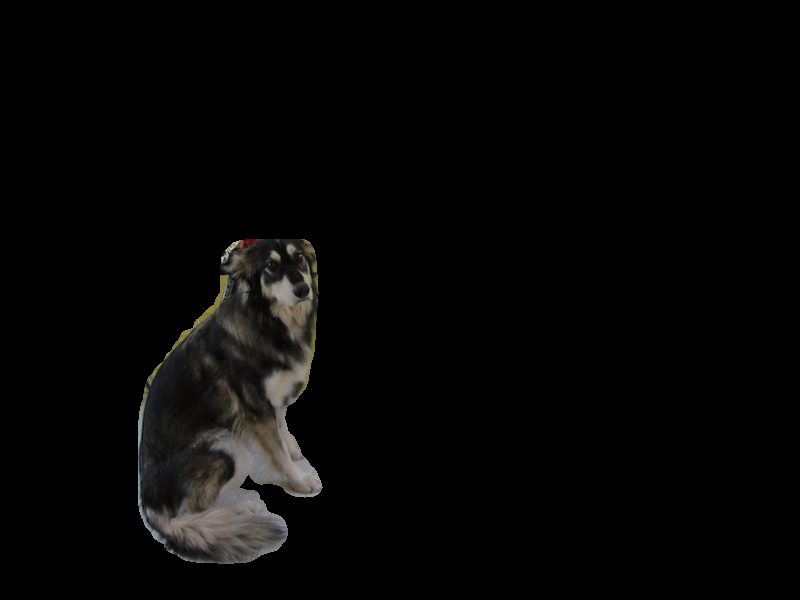

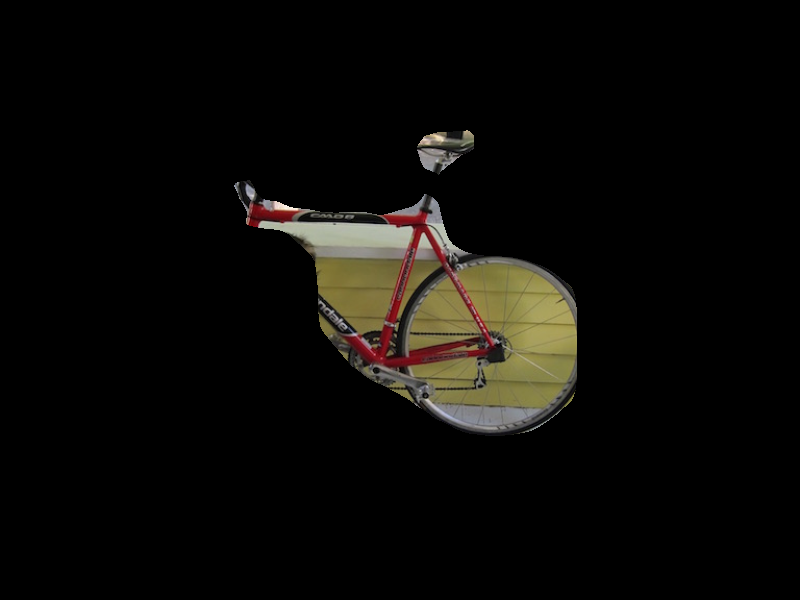

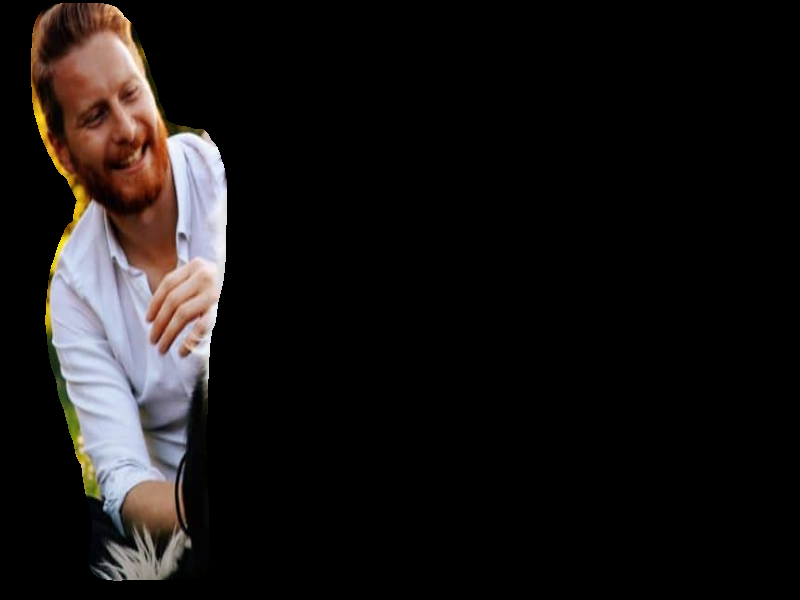

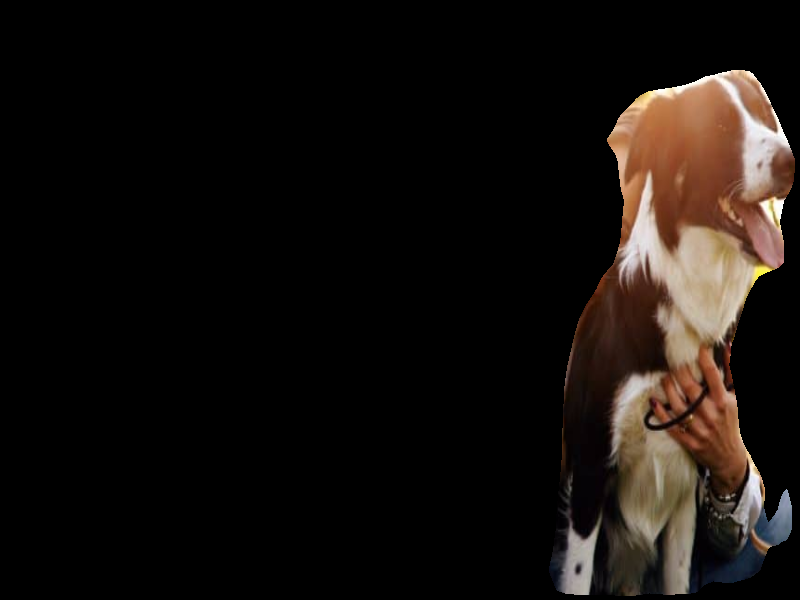

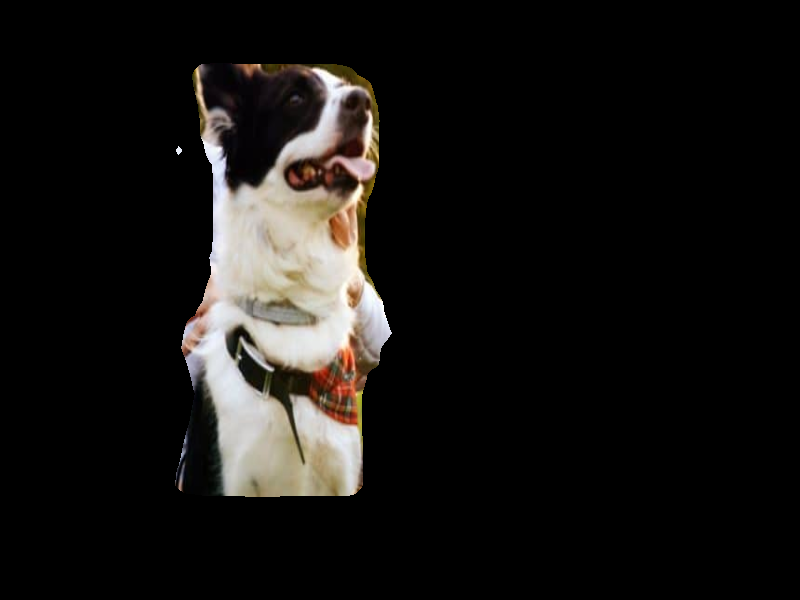

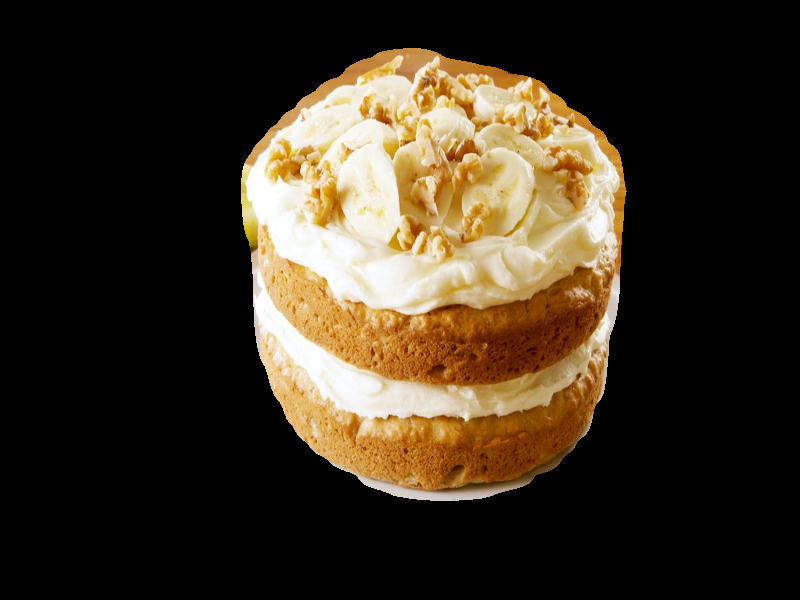

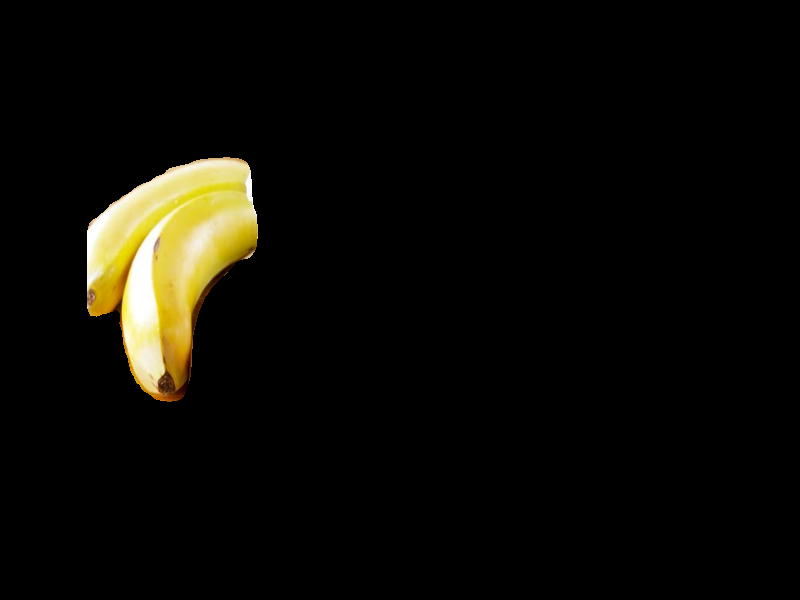

In [57]:
mask_img = []

for i in range(img_num):
    for j in range(len(outputs[i]["masks"])):
        outputs[i]["masks"][j] = np.where(outputs[i]["masks"][j] < 0.25, 0, 255)
        dst = input_data[i].copy()
        dst = cv2.bitwise_and(dst, dst, mask=outputs[i]["masks"][j].astype("uint8"))
        mask_img.append(dst)
        cv2_imshow(dst)

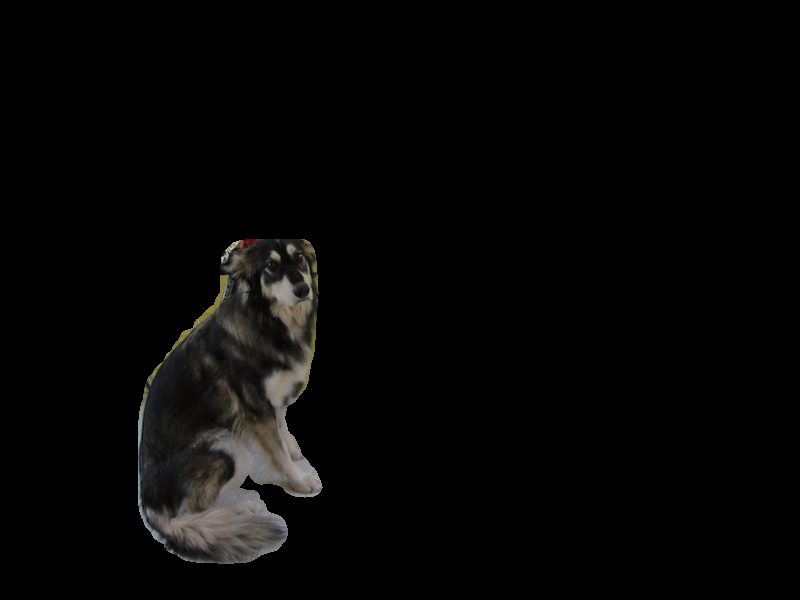

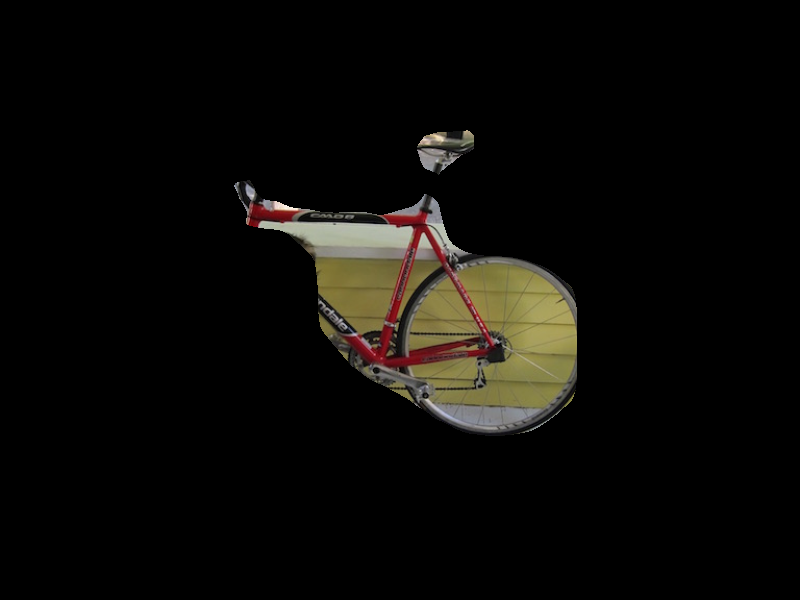

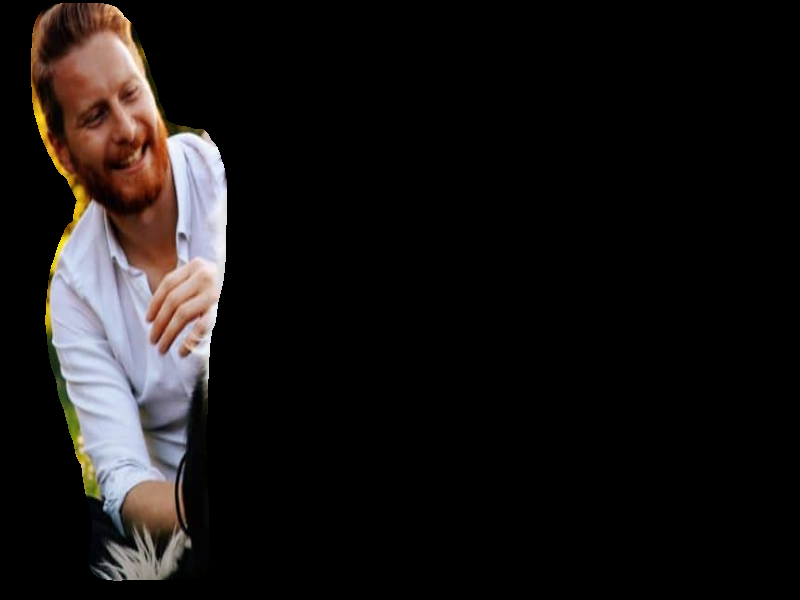

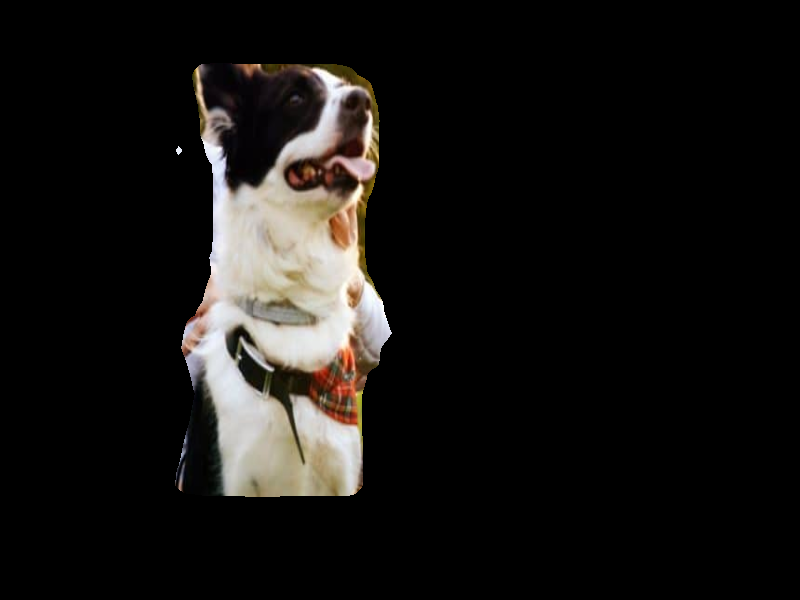

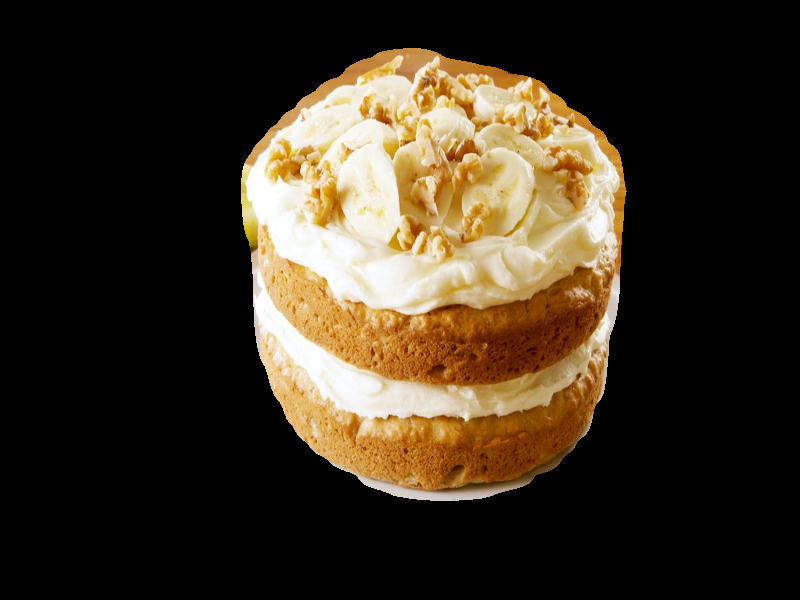

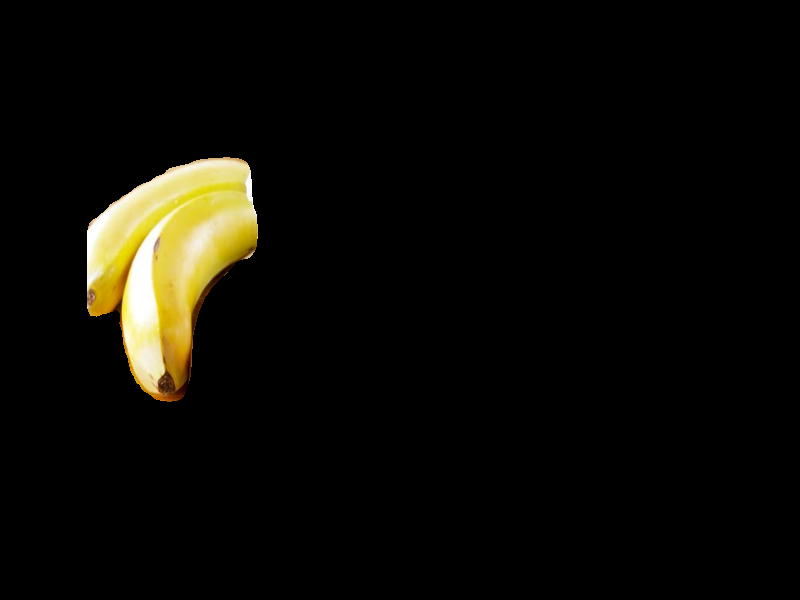

In [ ]:
for i in mask_img:
    cv2_imshow(i)